In [1]:
%matplotlib inline
from src.pgm import draw
from src.data import discretize, get_f1_score

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.models import BayesianModel

## ~~Replacing missing values with mean~~

In [2]:
# df = pd.read_csv("dataset/diabetes.csv")
# df.loc[:,'Glucose':'BMI'] = df.loc[:,'Glucose':'BMI'].replace(0,np.nan)
# df = df.fillna(df.mean()).astype({
#     "Pregnancies": "int32",
#     "Glucose": "int32",
#     "BloodPressure": "int32",
#     "SkinThickness": "int32",
#     "Insulin": "int32",
#     "BMI": "int32",
#     "DiabetesPedigreeFunction": "float",
#     "Age": "int32",
#     "Outcome": "category"
# })
# kbd = KBinsDiscretizer(n_bins=5, encode='ordinal').fit(df.drop(columns="Outcome"))
# df = discretize(kbd, df)
# train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

## Get dataset fixed with based on knowledge Bayesian Model 

In [3]:
from src.data import get_fixed_with_bn_dataset
df, kbd = get_fixed_with_bn_dataset(return_kbd=True)
train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

100%|██████████| 140/140 [00:00<00:00, 477.12it/s]


# Model uproszczony
Rozważamy tylko zmienne:
- Glucose
- Insulin
- SkinThickness
- Outcome

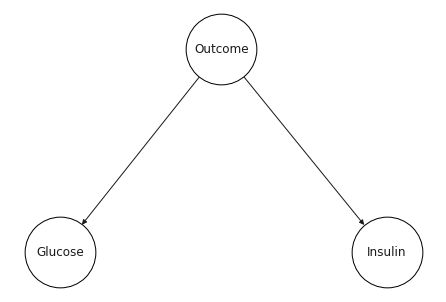

In [4]:
bn = BayesianModel([
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
])
bn.fit(train[["Glucose", "Insulin", "Outcome"]])
draw(bn)

In [5]:
y_pred = bn.predict(test[["Glucose", "Insulin"]])
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 21/21 [00:00<00:00, 4299.75it/s]F1-score: 0.77
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        72
           1       0.70      0.86      0.77        37

    accuracy                           0.83       109
   macro avg       0.81      0.84      0.82       109
weighted avg       0.84      0.83      0.83       109




# Pełen model
Wpierw badamy wyniki zwracane przez modele, których struktura wynika ze zgromadzonej wiedzy o problemie.
Wiemy, że cukrzycy 

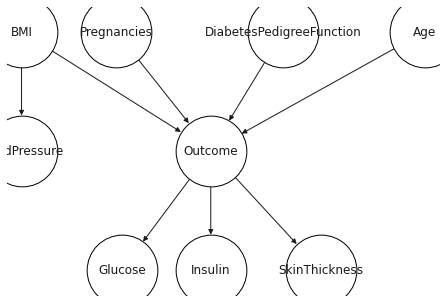

100%|██████████| 109/109 [00:01<00:00, 87.77it/s]
F1-score: 0.67
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        72
           1       0.61      0.76      0.67        37

    accuracy                           0.75       109
   macro avg       0.73      0.75      0.74       109
weighted avg       0.77      0.75      0.76       109



In [6]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Outcome", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

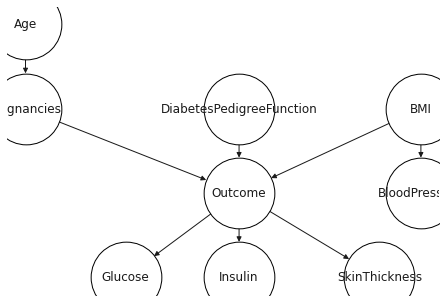

100%|██████████| 109/109 [00:00<00:00, 483.02it/s]
F1-score: 0.73
              precision    recall  f1-score   support

           0       0.90      0.76      0.83        72
           1       0.65      0.84      0.73        37

    accuracy                           0.79       109
   macro avg       0.77      0.80      0.78       109
weighted avg       0.81      0.79      0.79       109



In [7]:
bn = BayesianModel([
    ("Age", "Pregnancies"),
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Outcome", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

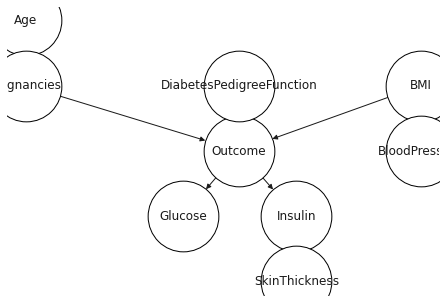

100%|██████████| 109/109 [00:00<00:00, 299.78it/s]
F1-score: 0.75
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        72
           1       0.67      0.86      0.75        37

    accuracy                           0.81       109
   macro avg       0.79      0.82      0.80       109
weighted avg       0.83      0.81      0.81       109



In [16]:
bn = BayesianModel([
    ("Age", "Pregnancies"),
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Insulin", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

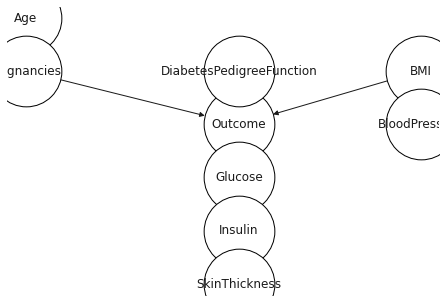

100%|██████████| 109/109 [00:00<00:00, 481.35it/s]
F1-score: 0.60
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        72
           1       0.57      0.62      0.60        37

    accuracy                           0.72       109
   macro avg       0.69      0.69      0.69       109
weighted avg       0.72      0.72      0.72       109



In [9]:
bn = BayesianModel([
    ("Age", "Pregnancies"),
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Outcome", "Glucose"),
    ("Glucose", "Insulin"),
    ("Insulin", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

# Poszukiwanie architektury grafu

  0%|          | 8/1000000 [00:00<28:14:11,  9.84it/s]


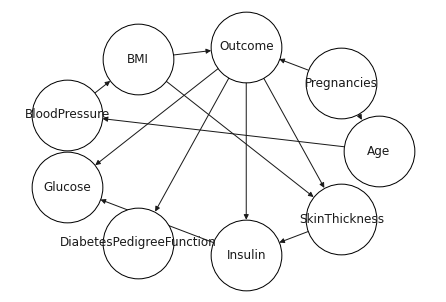

100%|██████████| 109/109 [00:00<00:00, 315.69it/s]
F1-score: 0.78
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        72
           1       0.74      0.84      0.78        37

    accuracy                           0.84       109
   macro avg       0.82      0.84      0.83       109
weighted avg       0.85      0.84      0.85       109



In [10]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score


bn_hc = HillClimbSearch(df).estimate(
    scoring_method=K2Score(df),
    start_dag=BayesianModel(list(bn.edges)),
)
draw(bn_hc, layout="kamada_kawai_layout", scale=40);
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

### Configuring edges
Warning: every time graph change, code in cell bellow could raise error.

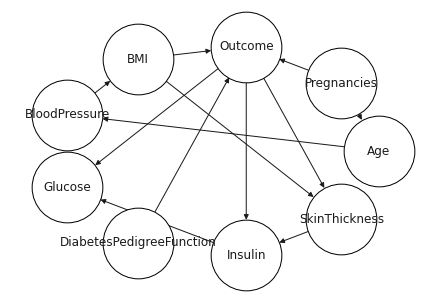

In [12]:
bn_hc.remove_edge("Outcome", "DiabetesPedigreeFunction")
bn_hc.add_edge("DiabetesPedigreeFunction", "Outcome")

draw(bn_hc, layout="kamada_kawai_layout", scale=40);

In [13]:
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 109/109 [00:00<00:00, 224.02it/s]
F1-score: 0.75
              precision    recall  f1-score   support

           0       0.89      0.82      0.86        72
           1       0.70      0.81      0.75        37

    accuracy                           0.82       109
   macro avg       0.80      0.82      0.80       109
weighted avg       0.83      0.82      0.82       109



In [14]:
from pgmpy.estimators import PC
pc_est = PC(data=df)
skeleton_pc, separating_sets_pc = pc_est.build_skeleton(variant='parallel')

amples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Insulin ⟂ Outcome | Glucose=2.0, Age=1, SkinThickness=1.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Insulin ⟂ Outcome | Glucose=2.0, Age=1, SkinThickness=2.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Insulin ⟂ Outcome | Glucose=2.0, Age=1, SkinThickness=3.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test SkinThickness ⟂ Outcome | Glucose=2.0, Age=3, Insulin=0.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Age ⟂ Outcome | Glucose=2.

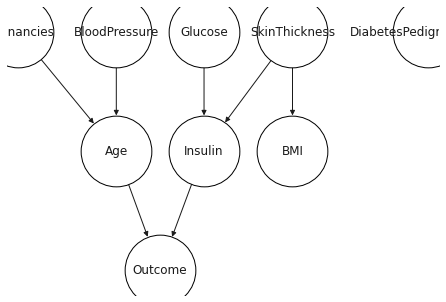

100%|██████████| 109/109 [00:00<00:00, 460.83it/s]
F1-score: 0.79
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        72
           1       0.77      0.81      0.79        37

    accuracy                           0.85       109
   macro avg       0.83      0.84      0.84       109
weighted avg       0.86      0.85      0.85       109



In [15]:
bn_pc = BayesianModel(skeleton_pc.edges)
bn_pc.add_nodes_from(bn)
bn_pc.fit(train)
draw(bn_pc)
y_pred = bn_pc.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)